In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, abs
import time
import mlflow
import mlflow.spark



# Initialize a Spark session with 2 local workers
spark = SparkSession.builder \
    .master("local[2]") \
    .appName("Book Impact Prediction") \
    .getOrCreate()

file_path = './book_featured_data.parquet'  

df = spark.read.parquet(file_path)

# Splitting the dataset
(train_df, test_df) = df.randomSplit([0.8, 0.2], seed=42)


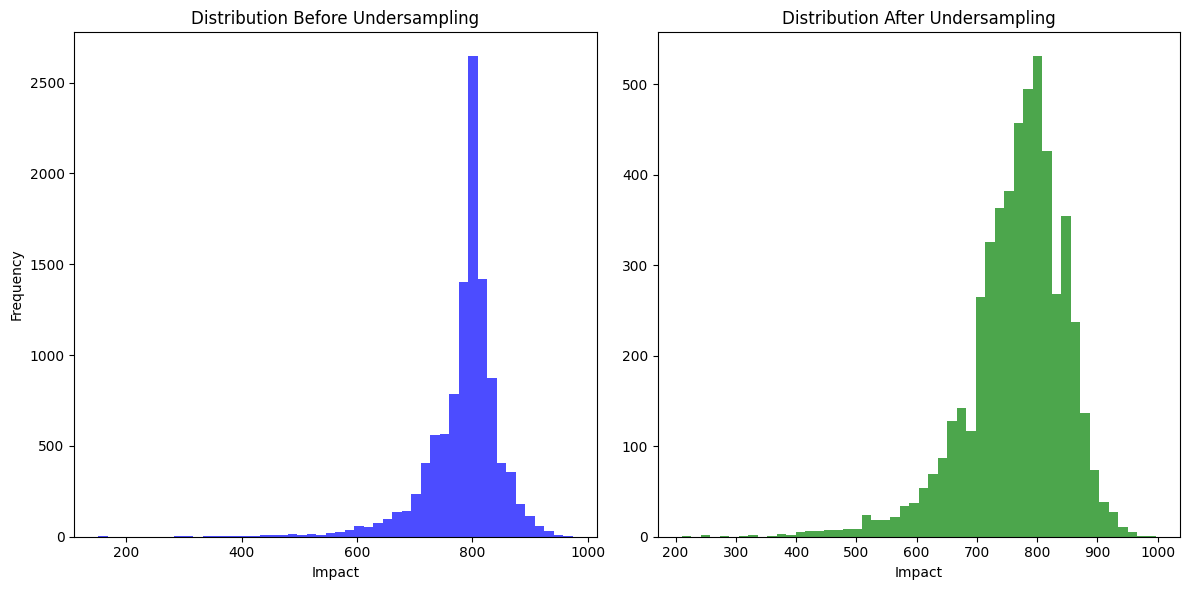

In [8]:
# Undersampling the train_df to reduce the skew 

# Define the percentile bins
percentile_bins = [0.0, 718.3813652211307, 755.9182978039748, 776.2309491765689,
                   784.3039243054303, 805.568540, 805.568540, 812.2857832807687,
                   823.9607318560921, 845.4664825825195, 1000.0]


# Bucket 1: 0.0 to 718.3813652211307
# Bucket 2: 718.3813652211307 to 755.9182978039748
# Bucket 3: 755.9182978039748 to 776.2309491765689
# Bucket 4: 776.2309491765689 to 784.3039243054303
# Bucket 5: 784.3039243054303 to 805.5685400829483
# Bucket 6:805.5685400829483  to 805.5685400829483
# Bucket 7:805.5685400829483  to 812.2857832807687
# Bucket 8: 812.2857832807687 to 823.9607318560921
# Bucket 9: 823.9607318560921 to 845.4664825825195
# Bucket 10: 845.4664825825195 to 1000.0


# Function to determine the bucket for each record
def get_bucket(value):
    for i in range(len(percentile_bins) - 1):
        if percentile_bins[i] <= value < percentile_bins[i + 1]:
            return i
    return len(percentile_bins) - 1  # Last bucket

# Register the UDF
bucket_udf = udf(get_bucket, IntegerType())

# Add a bucket column to the DataFrame
train_df = train_df.withColumn("bucket", bucket_udf(col("Impact")))

# Define undersampling rates for each bucket (example rates)
undersampling_rates = {0: 1.0
                       , 1: .7
                       , 2: .6
                       , 3: .6
                       , 4: .3
                       , 5: .3
                       , 6: .15
                       , 7: .3
                       , 8: .35
                       , 9: .7
                       , 10: 1.0
                       }

# Apply undersampling
undersampled_dfs = []
for bucket, rate in undersampling_rates.items():
    bucket_df = train_df.filter(col("bucket") == bucket)
    sampled_df = bucket_df.sample(False, rate, seed=42)
    undersampled_dfs.append(sampled_df)

# Combine undersampled data
undersampled_train_df = undersampled_dfs[0]
for df in undersampled_dfs[1:]:
    undersampled_train_df = undersampled_train_df.union(df)

# Collect data for plotting (use a small sample to avoid memory issues)
plot_data_before = train_df.sample(False, 0.1, seed=42).select("Impact").toPandas()
plot_data_after = undersampled_train_df.sample(False, 0.1, seed=42).select("Impact").toPandas()

# Plotting
plt.figure(figsize=(12, 6))

# Before undersampling
plt.subplot(1, 2, 1)
plt.hist(plot_data_before['Impact'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution Before Undersampling')
plt.xlabel('Impact')
plt.ylabel('Frequency')

# After undersampling
plt.subplot(1, 2, 2)
plt.hist(plot_data_after['Impact'], bins=50, color='green', alpha=0.7)
plt.title('Distribution After Undersampling')
plt.xlabel('Impact')

plt.tight_layout()
plt.show()

In [11]:
# MLflow setup
experiment_name = "Model_Impact_v2"
experiment_id = mlflow.create_experiment(experiment_name) if not mlflow.get_experiment_by_name(experiment_name) else mlflow.get_experiment_by_name(experiment_name).experiment_id
print(experiment_id)
mlflow.set_experiment(experiment_name)

# Worker configurations
worker_configs = [1, 2, 4]

# Define the ML pipeline
regressor = RandomForestRegressor(featuresCol="features", labelCol="Impact", maxBins=12852)
pipeline = Pipeline(stages=[regressor])

# Evaluator for MAE
evaluator = RegressionEvaluator(labelCol="Impact", predictionCol="prediction", metricName="mae")

# Custom Function to calculate MAPE
def calculate_mape(df):
    df_with_error = df.withColumn("ape", (abs(col("prediction") - col("Impact")) / col("Impact")))
    return df_with_error.select(avg(col("ape"))).collect()[0][0] * 100

for workers in worker_configs:
    print('Setting Worker:',workers)
    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("ImpactPrediction") \
        .config("spark.executor.instances", workers) \
        .getOrCreate()


    # Start MLflow run
    with mlflow.start_run():
        mlflow.log_param("workers", workers)

        # Start timer
        start_time = time.time()

        # Fit the model
        print('Start Model Training..')
        model = pipeline.fit(undersampled_train_df)

        # End timer and log training time
        training_time = time.time() - start_time
        mlflow.log_metric("training_time", training_time)

        # Evaluate on training data
        print('Evaluating Model..')
        train_predictions = model.transform(undersampled_train_df)
        train_mae = evaluator.evaluate(train_predictions)
        train_mape = calculate_mape(train_predictions)
        mlflow.log_metric("train_mae", train_mae)
        mlflow.log_metric("train_mape", train_mape)

        # Evaluate on test data
        test_predictions = model.transform(test_df)
        test_mae = evaluator.evaluate(test_predictions)
        test_mape = calculate_mape(test_predictions)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("test_mape", test_mape)

        # Log the model
        mlflow.spark.log_model(model, "model")

    # Stop the Spark session



948780832202812237
Setting Worker: 1


24/01/01 13:36:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Start Model Training..


24/01/01 13:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1232.4 KiB
24/01/01 13:37:17 WARN DAGScheduler: Broadcasting large task binary with size 1739.2 KiB
24/01/01 13:37:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/01/01 13:37:36 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


Evaluating Model..


24/01/01 13:38:21 WARN TaskSetManager: Stage 39 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.
2024/01/01 13:38:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/0q/qlkxsyj53fzdzkkvvwlwrk4m0000gn/T/tmpr39qq36r/model, flavor: spark), fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback.
/Users/apple/Book-Impact/env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
24/01/01 13:38:52 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Setting Worker: 2
Start Model Training..


24/01/01 13:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1232.4 KiB
24/01/01 13:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1739.2 KiB
24/01/01 13:39:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/01/01 13:39:41 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


Evaluating Model..


24/01/01 13:40:26 WARN TaskSetManager: Stage 70 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.
2024/01/01 13:40:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/0q/qlkxsyj53fzdzkkvvwlwrk4m0000gn/T/tmpz90tx72o/model, flavor: spark), fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback.
24/01/01 13:40:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Setting Worker: 4
Start Model Training..


24/01/01 13:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1232.4 KiB
24/01/01 13:41:24 WARN DAGScheduler: Broadcasting large task binary with size 1739.2 KiB
24/01/01 13:41:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/01/01 13:41:46 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


Evaluating Model..


24/01/01 13:42:29 WARN TaskSetManager: Stage 101 contains a task of very large size (1023 KiB). The maximum recommended task size is 1000 KiB.
2024/01/01 13:42:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/0q/qlkxsyj53fzdzkkvvwlwrk4m0000gn/T/tmpgc_9q1jx/model, flavor: spark), fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback.


In [ ]:
spark.stop()